IMPORT LIBRERIE 

In [84]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

Caricamento dataset


In [85]:
df = pd.read_csv('train.csv')

Rimuovo Cabin


In [86]:

df = df.drop(columns=["Cabin"])

estraggo il numerico da ticket 

In [87]:


def extract_numeric(x):
    if pd.isna(x): return np.nan
    m = re.findall(r"[-+]?\d*\.?\d+", str(x))
    return float(m[0]) if m else np.nan
df["Ticket"] = df["Ticket"].apply(extract_numeric)
df["Ticket"] = df["Ticket"].fillna(df["Ticket"].median())


RIEMPIO I VALORI NAN CON MEDIANA E MODA 

In [88]:
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])


RIMUOVO GLI OUTLLIER SULLE COLONNE NUMERICHE 

In [89]:
for col in ["Age", "Fare", "Ticket"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = np.clip(df[col], Q1 - 1.5*IQR, Q3 + 1.5*IQR)


ESTRAGGO SOLO IL TITLE DA NAME PER ADDESTRARE IL MODELLO ANCHE IN BASE AL TITLE( RAGGRUPPO TUTTI I TITLE SPECIALI IN RARE_TITLE )

In [90]:
df["Title"] = df["Name"].str.extract(r",\s*([^\.]*)\.")
rare_titles = ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"]
df["Title"] = df["Title"].replace(rare_titles, "Rare")
df["Title"] = df["Title"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"})
df = df.drop(columns=["Name"])

 Encoding categorici


In [91]:
df["Sex"] = df["Sex"].map({"male":0,"female":1})
title_mapping = {"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Rare":4}
df["Title"] = df["Title"].map(title_mapping)
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

Nuove feature


In [92]:


df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"]==1).astype(int)

Split features/target e train/validation

In [93]:

X = df.drop(columns=["Survived","PassengerId"])
y = df["Survived"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

 Standardizzazione numeriche

In [94]:


num_cols = ["Age","Fare","Ticket","FamilySize"]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])


Modello RandomForest

In [95]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
score = model.score(X_valid, y_valid)
print("Accuracy:", score)

Accuracy: 0.8268156424581006


optuna con pruner

In [111]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    
    # Prune se il trial va male
    trial.report(scores.mean(), step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return scores.mean()

# Creazione dello study con pruning
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
    study_name="Titanic"
)
study.optimize(objective, n_trials=100)


[I 2025-12-05 12:23:58,309] A new study created in memory with name: Titanic


[I 2025-12-05 12:24:02,648] Trial 0 finished with value: 0.8342657342657344 and parameters: {'n_estimators': 449, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8342657342657344.
[I 2025-12-05 12:24:11,798] Trial 1 finished with value: 0.837062937062937 and parameters: {'n_estimators': 947, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.837062937062937.
[I 2025-12-05 12:24:17,844] Trial 2 finished with value: 0.8342952821826062 and parameters: {'n_estimators': 653, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.837062937062937.
[I 2025-12-05 12:24:27,657] Trial 3 finished with value: 0.8342558849601105 and parameters: {'n_estimators': 978, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.837062937062937.
[I 2025-12-05 12:24:35,565] Trial 4 finished with value: 0.8356643356643356 and parameters: {'n

In [112]:
print("Best trial parameters:", study.best_trial.params)
print("Best trial value:", study.best_trial.value)

Best trial parameters: {'n_estimators': 477, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}
Best trial value: 0.8398798384713878


PRENDO I PARAMETRI MIGLIORI DA OPTUNA E CREO IL MODELLO FINALE 


In [113]:
from sklearn.ensemble import RandomForestClassifier

best_params = {
    'n_estimators': 222,
    'max_depth': 12,
    'min_samples_split': 9,
    'min_samples_leaf': 2,
    'random_state': 42
}

final_model = RandomForestClassifier(**best_params)


In [ ]:
import optuna.visualization as ov

In [114]:
final_model.fit(X_train, y_train)


,n_estimators,222
,criterion,'gini'
,max_depth,12
,min_samples_split,9
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AllinO colonne tra train e validation E VEDO L'ACCURACY 

In [115]:
X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)

score = final_model.score(X_valid, y_valid)
print("Accuracy sul validation set:", score)


Accuracy sul validation set: 0.8379888268156425


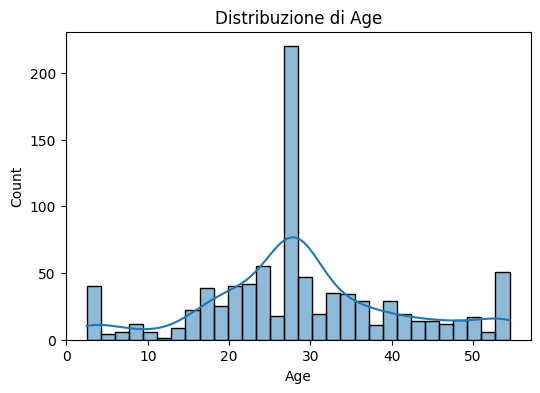

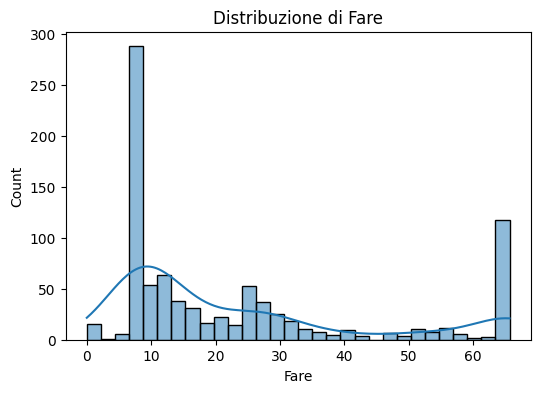

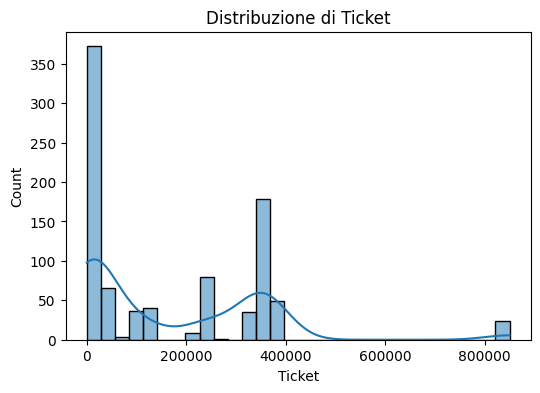

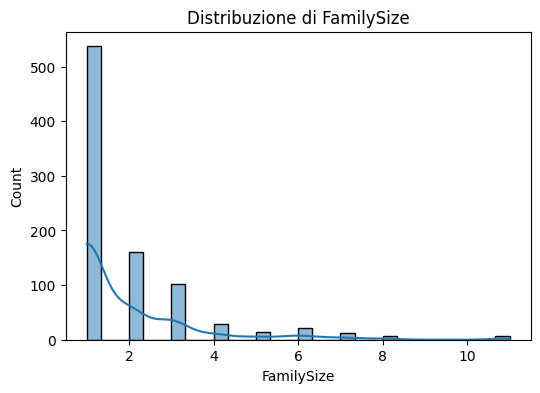

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ["Age", "Fare", "Ticket", "FamilySize"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribuzione di {col}')
    plt.show()


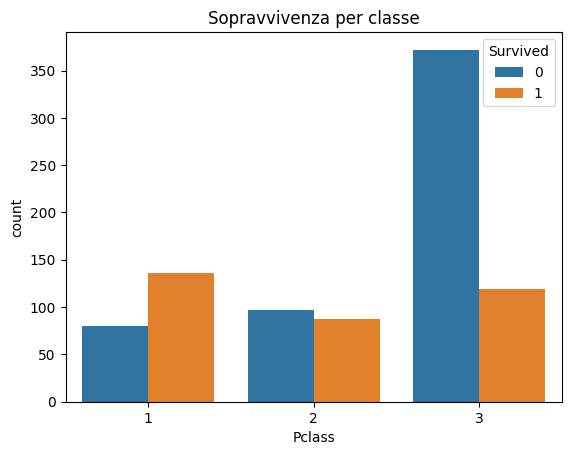

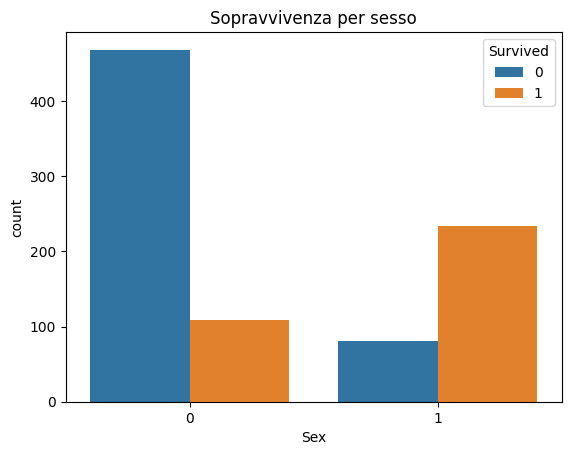

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Sopravvivenza per classe")
plt.show()

sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Sopravvivenza per sesso")
plt.show()


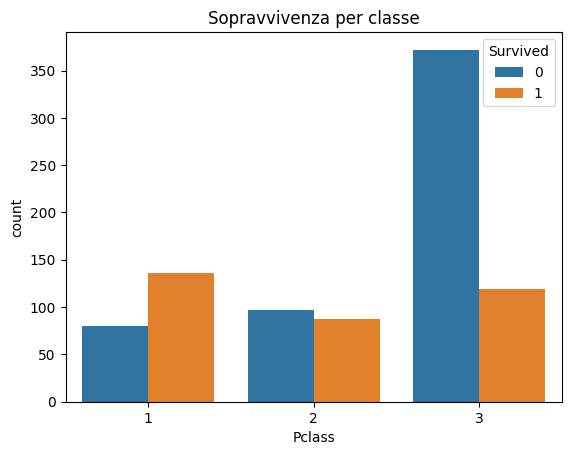

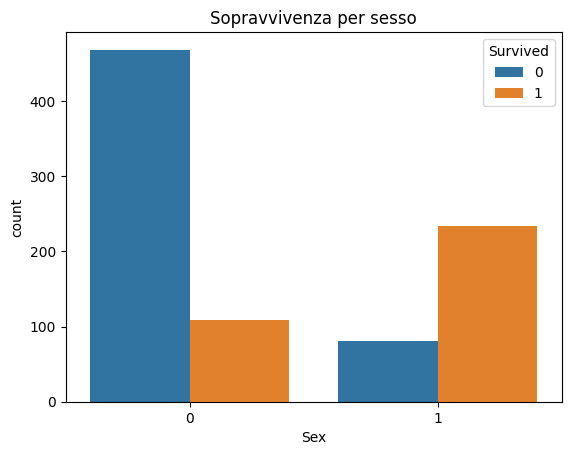

In [118]:
sns.countplot(data=df, x="Pclass", hue="Survived")
plt.title("Sopravvivenza per classe")
plt.show()

sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Sopravvivenza per sesso")
plt.show()


In [2]:
import optuna
import optuna.visualization as vis

# --- 4️⃣ Creazione study e ottimizzazione ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

# --- 5️⃣ Grafico storia ottimizzazione ---
fig = vis.plot_optimization_history(study)
fig.show(renderer="browser")

[I 2025-12-05 12:56:08,438] A new study created in memory with name: no-name-8469bacc-cf28-4d79-b7c6-a2cbdd1ff6be
[I 2025-12-05 12:56:08,484] Trial 0 finished with value: 628.6072711533574 and parameters: {'x': -25.091976230527507, 'y': -1}. Best is trial 0 with value: 628.6072711533574.
[I 2025-12-05 12:56:08,487] Trial 1 finished with value: 4733.92702892279 and parameters: {'x': -68.79627191151269, 'y': 1}. Best is trial 1 with value: 4733.92702892279.
[I 2025-12-05 12:56:08,489] Trial 2 finished with value: 409.96982399317 and parameters: {'x': 20.223002348641756, 'y': 1}. Best is trial 1 with value: 4733.92702892279.
[I 2025-12-05 12:56:08,490] Trial 3 finished with value: 4419.724376894329 and parameters: {'x': 66.48852816008434, 'y': -1}. Best is trial 1 with value: 4733.92702892279.
[I 2025-12-05 12:56:08,491] Trial 4 finished with value: 1531.8439776605067 and parameters: {'x': -39.15155140809246, 'y': -1}. Best is trial 1 with value: 4733.92702892279.
[I 2025-12-05 12:56:08,4